In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 定义数据增强和归一化
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # 提高分辨率
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 加载数据集
train_dir = r"E:\Pythonworkshop\Dataset\Car_damage_detection_data\data1a\training"
test_dir = r"E:\Pythonworkshop\Dataset\Car_damage_detection_data\data1a\validation"

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [2]:
# import torch.nn as nn
# import torch.nn.functional as F

# class CarDamageModel(nn.Module):
#     def __init__(self):
#         super(CarDamageModel, self).__init__()
#         # 定义卷积层
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout1 = nn.Dropout(0.3)

#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.dropout2 = nn.Dropout(0.3)

#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.dropout3 = nn.Dropout(0.4)

#         # 占位的线性层
#         self.fc1 = None
#         self.dropout4 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(128, 2)  # 输出2个类别

#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.dropout1(x)

#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = self.dropout2(x)

#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         x = self.dropout3(x)

#         # 动态计算展平后的张量大小
#         if self.fc1 is None:
#             flattened_size = x.size(1) * x.size(2) * x.size(3)
#             self.fc1 = nn.Linear(flattened_size, 128).to(x.device)

#         x = torch.flatten(x, 1)  # 动态展平
#         x = F.relu(self.fc1(x))
#         x = self.dropout4(x)

#         x = F.softmax(self.fc2(x), dim=1)  # Softmax 输出
#         return x


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 如果通道数或空间大小不匹配，定义下采样
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x  # 保存输入值

        # 主路径
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # 如果需要，下采样输入
        if self.downsample:
            identity = self.downsample(x)

        # 残差连接
        out += identity
        return F.relu(out)

    
class CarDamageModelWithResiduals(nn.Module):
    def __init__(self):
        super(CarDamageModelWithResiduals, self).__init__()
        # 输入层（无残差）
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)  

        # 残差模块
        self.residual_block1 = ResidualBlock(32, 64, stride=1)
        self.residual_block2 = ResidualBlock(64, 128, stride=1)
        self.residual_block3 = ResidualBlock(128, 256, stride=1)

        # 全连接层
        self.fc1 = None  # 动态初始化
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # 初始卷积层
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        #print(f"Shape after initial conv and pool: {x.shape}")

        # 残差块1
        x = self.residual_block1(x)
        #print(f"Shape after residual block 1: {x.shape}")

        # 残差块2
        x = self.residual_block2(x)
        #print(f"Shape after residual block 2: {x.shape}")

        # 残差块3
        x = self.residual_block3(x)
        #print(f"Shape after residual block 3: {x.shape}")

        # 动态展平
        if self.fc1 is None:
            flattened_size = x.size(1) * x.size(2) * x.size(3)
            self.fc1 = nn.Linear(flattened_size, 128).to(x.device)

        x = torch.flatten(x, 1)
        #print(f"Shape after flatten: {x.shape}")

        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x



In [4]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = CarDamageModel().to(device)
model = CarDamageModelWithResiduals().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1/50, Loss: 0.6570378069219918
Epoch 2/50, Loss: 0.6144477108429218
Epoch 3/50, Loss: 0.5894671370243204
Epoch 4/50, Loss: 0.5658978254630648
Epoch 5/50, Loss: 0.5451180128187969
Epoch 6/50, Loss: 0.528220516854319
Epoch 7/50, Loss: 0.5153271057482424
Epoch 8/50, Loss: 0.5113760078775471
Epoch 9/50, Loss: 0.5101353813861979
Epoch 10/50, Loss: 0.4997191634671441
Epoch 11/50, Loss: 0.49134058633754996
Epoch 12/50, Loss: 0.48601170654954584
Epoch 13/50, Loss: 0.47274918751469974
Epoch 14/50, Loss: 0.47733884895670003
Epoch 15/50, Loss: 0.4767662923911522
Epoch 16/50, Loss: 0.46974269480540837
Epoch 17/50, Loss: 0.46174880399786195
Epoch 18/50, Loss: 0.45961596585553266
Epoch 19/50, Loss: 0.4589187112347833
Epoch 20/50, Loss: 0.453672653642194
Epoch 21/50, Loss: 0.45366023532275496
Epoch 22/50, Loss: 0.4524012927351327
Epoch 23/50, Loss: 0.44608252623985556
Epoch 24/50, Loss: 0.45054865500022623
Epoch 25/50, Loss: 0.43342191700277655
Epoch 26/50, Loss: 0.4432293140682681
Epoch 27/50,

In [6]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 84.57%


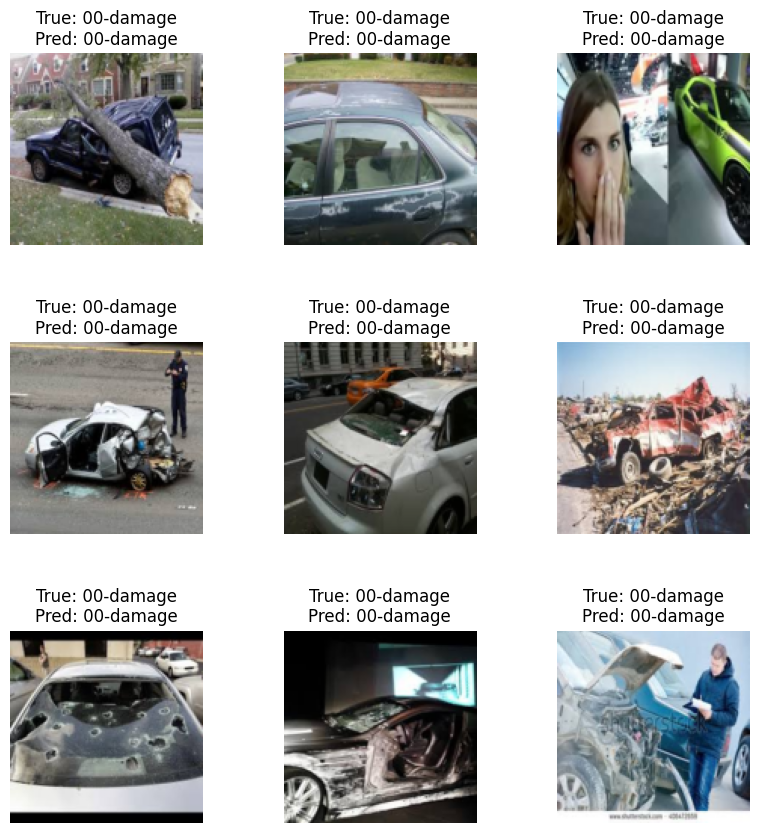

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 随机选择一批数据
data_iter = iter(test_loader)
images, labels = next(data_iter)

images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# 将数据从 GPU 移到 CPU 并反归一化
images = images.cpu().numpy().transpose(0, 2, 3, 1)
images = (images * 0.5) + 0.5  # 反归一化

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"True: {train_dataset.classes[labels[i]]}\nPred: {train_dataset.classes[predicted[i]]}")
    ax.axis('off')

plt.show()
